In [54]:
import shutil
import os

# This is where kagglehub usually stores datasets
cache_path = os.path.expanduser("~/.cache/kagglehub")

# Delete the entire kagglehub cache directory
if os.path.exists(cache_path):
    shutil.rmtree(cache_path)
    print("✅ Deleted KaggleHub cache at:", cache_path)
else:
    print("⚠️ KaggleHub cache not found at:", cache_path)

✅ Deleted KaggleHub cache at: /home/elicer/.cache/kagglehub


In [55]:
#only using faster_gaussian() for all dataset

import cv2
print(cv2.__version__)
import torch
print(torch.__version__)
print(torch.rand(2, 3))

import h5py
import scipy.io as io
import PIL.Image as Image
import numpy as np
import os
import glob
from matplotlib import pyplot as plt
from scipy.ndimage import gaussian_filter
import scipy
import json
from matplotlib import cm as CM
from image import *
from model import CSRNet
import torch
%matplotlib inline

4.11.0
2.7.0+cpu
tensor([[0.5683, 0.9193, 0.2611],
        [0.6839, 0.7897, 0.8533]])


In [56]:
#using faster approximation of adaptive_gaussian()

def faster_gaussian(gt):
    print(gt.shape)
    density = np.zeros(gt.shape, dtype=np.float32)
    gt_count = np.count_nonzero(gt)
    if gt_count == 0:
        return density
    
    pts = np.array(list(zip(np.nonzero(gt)[1], np.nonzero(gt)[0])))
    #this return (y_indices, x_indices)

    for x, y in pts:
        density[y, x] = 1. #mark the points(=heads) in the .mat with 1 

    print('generate density...')
    
    #use mean distance as one global σ
    
    if gt_count > 1:
        leafsize = 512
        tree = scipy.spatial.KDTree(pts.copy(), leafsize=leafsize)
        #builf kdtree to find 3 nearest neighbours
        distances, _ = tree.query(pts, k=4)
        sigma = np.mean(distances[:, 1:]) * 0.1 #skip the first column of distance to itself
    else: #take avg of all dist and scale by 0,1-> our single sigma
        sigma = np.average(np.array(gt.shape)) / 4.

    #apply one global Gaussian blur using the computed sigma
    density = scipy.ndimage.gaussian_filter(density, sigma, mode='constant')

    print('done.')
    return density

#very fast since only 1 blur total

#The original method loops through every head and blurs it individually, which is accurate but slow.
#In the optimized version, we approximate the average spacing between heads and use it to apply a single Gaussian blur to the entire map.”
#This change maintains a good estimate of density while improving speed significantly.”

In [57]:
!pip install kagglehub

import kagglehub
path = kagglehub.dataset_download("tthien/shanghaitech")

print("Path to dataset files:", path)


Defaulting to user installation because normal site-packages is not writeable


100%|██████████| 333M/333M [01:07<00:00, 5.15MB/s] 

Extracting files...


Path to dataset files: /home/elicer/.cache/kagglehub/datasets/tthien/shanghaitech/versions/1


In [58]:
root = '/home/elicer/.cache/kagglehub/datasets/tthien/shanghaitech/versions/1/ShanghaiTech/'

In [59]:
#now generate the ShanghaiA's ground truth
part_A_train = os.path.join(root,'part_A/train_data','images')
part_A_test = os.path.join(root,'part_A/test_data','images')
part_B_train = os.path.join(root,'part_B/train_data','images')
part_B_test = os.path.join(root,'part_B/test_data','images')

path_setA = [part_A_train,part_A_test]
path_setB = [part_B_train,part_B_test]

In [60]:
#loop all dataset

import re
def sort_by_number(path):
    filename = os.path.basename(path)
    number = int(re.findall(r'\d+', filename)[0])
    return number


img_paths_A_train = sorted(glob.glob(os.path.join(part_A_train, '*.jpg')), key=sort_by_number)
img_paths_A_test  = sorted(glob.glob(os.path.join(part_A_test, '*.jpg')), key=sort_by_number)
img_paths_A = img_paths_A_train + img_paths_A_test
print(f"{len(img_paths_A)} images in Part A")


img_paths_B_train = sorted(glob.glob(os.path.join(part_B_train, '*.jpg')), key=sort_by_number)
img_paths_B_test  = sorted(glob.glob(os.path.join(part_B_test, '*.jpg')), key=sort_by_number)
img_paths_B = img_paths_B_train + img_paths_B_test
print(f"{len(img_paths_B)} images in Part B")


img_paths_all = img_paths_A + img_paths_B
print(f"🔁 Total combined images: {len(img_paths_all)}")

482 images in Part A
716 images in Part B
🔁 Total combined images: 1198


In [ ]:
#lets start! we will use faster_gaussian

In [61]:
#part A using faster gaussian

total = len(img_paths_A)
for idx, img_path in enumerate(img_paths_A):
    print(f"[A {idx+1}/{total}] Processing: {img_path}")

    mat = io.loadmat(img_path.replace('.jpg','.mat').replace('images','ground-truth').replace('IMG_','GT_IMG_'))
    img = plt.imread(img_path)

    k = np.zeros((img.shape[0], img.shape[1]))
    gt = mat["image_info"][0,0][0,0][0]
    for i in range(len(gt)):
        if int(gt[i][1]) < img.shape[0] and int(gt[i][0]) < img.shape[1]:
            k[int(gt[i][1]), int(gt[i][0])] = 1

    k = faster_gaussian(k)

    h5_path = img_path.replace('.jpg','.h5').replace('images','generated-h5')
    os.makedirs(os.path.dirname(h5_path), exist_ok=True)
    
   # if os.path.exists(h5_path):
   #     os.remove(h5_path)
   #     print(f"Deleted existing file: {h5_path}")
        
    with h5py.File(h5_path, 'w') as hf:
        hf['density'] = k

[A 1/482] Processing: /home/elicer/.cache/kagglehub/datasets/tthien/shanghaitech/versions/1/ShanghaiTech/part_A/train_data/images/IMG_1.jpg
(768, 1024)
generate density...
done.
[A 2/482] Processing: /home/elicer/.cache/kagglehub/datasets/tthien/shanghaitech/versions/1/ShanghaiTech/part_A/train_data/images/IMG_2.jpg
(713, 1024)
generate density...
done.
[A 3/482] Processing: /home/elicer/.cache/kagglehub/datasets/tthien/shanghaitech/versions/1/ShanghaiTech/part_A/train_data/images/IMG_3.jpg
(664, 1000)
generate density...
done.
[A 4/482] Processing: /home/elicer/.cache/kagglehub/datasets/tthien/shanghaitech/versions/1/ShanghaiTech/part_A/train_data/images/IMG_4.jpg
(746, 1024)
generate density...
done.
[A 5/482] Processing: /home/elicer/.cache/kagglehub/datasets/tthien/shanghaitech/versions/1/ShanghaiTech/part_A/train_data/images/IMG_5.jpg
(683, 1024)
generate density...
done.
[A 6/482] Processing: /home/elicer/.cache/kagglehub/datasets/tthien/shanghaitech/versions/1/ShanghaiTech/part_

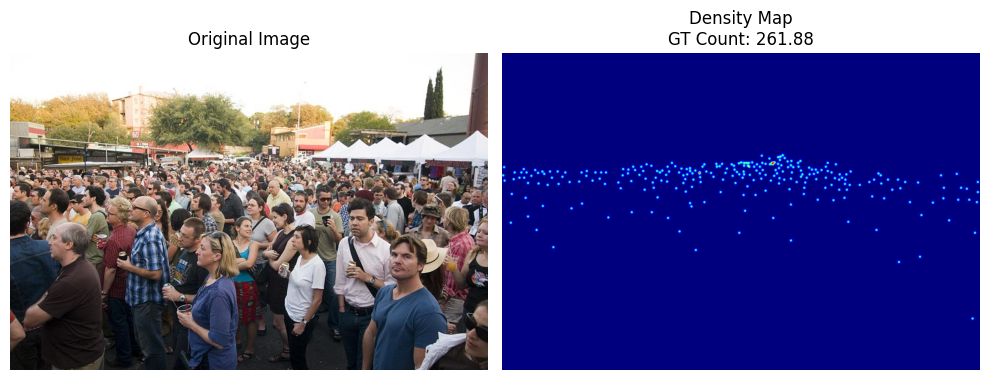

In [62]:
img_path = img_paths_A[2]

# Load the image
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Load the density map
h5_path = img_path.replace('.jpg','.h5').replace('images','generated-h5')
with h5py.File(h5_path, 'r') as hf:
    density_map = np.asarray(hf['density'])

# Display
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.imshow(img)
plt.axis('off')
plt.title('Original Image')

plt.subplot(1, 2, 2) 
plt.imshow(density_map, cmap=CM.jet)
plt.axis('off')
plt.title(f'Density Map\nGT Count: {density_map.sum():.2f}')

plt.tight_layout()
plt.show()

In [63]:
import scipy.io as io

img_path = img_paths_A[2]
mat_path = img_path.replace('.jpg', '.mat').replace('images', 'ground-truth').replace('IMG_', 'GT_IMG_')

mat = io.loadmat(mat_path)
gt = mat["image_info"][0, 0][0, 0][0]

actual_count = len(gt)
print(f"✅ Actual number of people in the image: {actual_count}")

✅ Actual number of people in the image: 262


In [ ]:
#ok now we do part B!

In [64]:
#part B using faster gaussian

total = len(img_paths_B)
for idx, img_path in enumerate(img_paths_B):
    print(f"[B {idx+1}/{total}] Processing: {img_path}")

    mat = io.loadmat(img_path.replace('.jpg','.mat').replace('images','ground-truth').replace('IMG_','GT_IMG_'))
    img = plt.imread(img_path)

    k = np.zeros((img.shape[0], img.shape[1]))
    gt = mat["image_info"][0,0][0,0][0]
    for i in range(len(gt)):
        if int(gt[i][1]) < img.shape[0] and int(gt[i][0]) < img.shape[1]:
            k[int(gt[i][1]), int(gt[i][0])] = 1

    k = faster_gaussian(k)

    h5_path = img_path.replace('.jpg','.h5').replace('images','generated-h5')
    os.makedirs(os.path.dirname(h5_path), exist_ok=True)
    
   # if os.path.exists(h5_path):
   #     os.remove(h5_path)
   #     print(f"Deleted existing file: {h5_path}")
        
    with h5py.File(h5_path, 'w') as hf:
        hf['density'] = k

[B 1/716] Processing: /home/elicer/.cache/kagglehub/datasets/tthien/shanghaitech/versions/1/ShanghaiTech/part_B/train_data/images/IMG_1.jpg
(768, 1024)
generate density...
done.
[B 2/716] Processing: /home/elicer/.cache/kagglehub/datasets/tthien/shanghaitech/versions/1/ShanghaiTech/part_B/train_data/images/IMG_2.jpg
(768, 1024)
generate density...
done.
[B 3/716] Processing: /home/elicer/.cache/kagglehub/datasets/tthien/shanghaitech/versions/1/ShanghaiTech/part_B/train_data/images/IMG_3.jpg
(768, 1024)
generate density...
done.
[B 4/716] Processing: /home/elicer/.cache/kagglehub/datasets/tthien/shanghaitech/versions/1/ShanghaiTech/part_B/train_data/images/IMG_4.jpg
(768, 1024)
generate density...
done.
[B 5/716] Processing: /home/elicer/.cache/kagglehub/datasets/tthien/shanghaitech/versions/1/ShanghaiTech/part_B/train_data/images/IMG_5.jpg
(768, 1024)
generate density...
done.
[B 6/716] Processing: /home/elicer/.cache/kagglehub/datasets/tthien/shanghaitech/versions/1/ShanghaiTech/part_

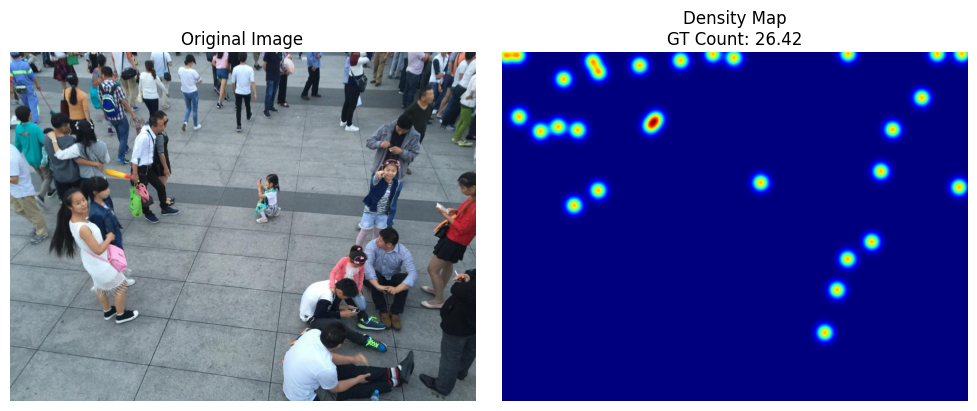

In [65]:
img_path = img_paths_B[2]

# Load the image
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Load the density map
h5_path = img_path.replace('.jpg','.h5').replace('images','generated-h5')
with h5py.File(h5_path, 'r') as hf:
    density_map = np.asarray(hf['density'])

# Display
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.imshow(img)
plt.axis('off')
plt.title('Original Image')

plt.subplot(1, 2, 2) 
plt.imshow(density_map, cmap=CM.jet)
plt.axis('off')
plt.title(f'Density Map\nGT Count: {density_map.sum():.2f}')

plt.tight_layout()
plt.show()

In [66]:
import scipy.io as io

img_path = img_paths_B[2]
mat_path = img_path.replace('.jpg', '.mat').replace('images', 'ground-truth').replace('IMG_', 'GT_IMG_')

mat = io.loadmat(mat_path)
gt = mat["image_info"][0, 0][0, 0][0]

actual_count = len(gt)
print(f"✅ Actual number of people in the image: {actual_count}")

✅ Actual number of people in the image: 29


In [ ]:
#check if they all got .h5 files

In [67]:
import os

missing_h5 = []

for img_path in img_paths_all:
    # Get expected .h5 path
    h5_path = img_path.replace('.jpg', '.h5').replace('images', 'generated-h5')
    
    if not os.path.exists(h5_path):
        missing_h5.append(h5_path)

# Report
if missing_h5:
    print(f"❌ Missing {len(missing_h5)} .h5 files:")
    for path in missing_h5[:10]:  # show only first 10
        print("  -", path)
else:
    print("✅ All .h5 files are present for every image.")

✅ All .h5 files are present for every image.


In [68]:
import json
import os

def create_json(img_paths, json_path):
    data = []
    for img_path in img_paths:
        h5_path = img_path.replace('.jpg', '.h5').replace('images', 'generated-h5')
        data.append({
            "image": img_path,
            "density": h5_path
        })
    with open(json_path, 'w') as f:
        json.dump(data, f, indent=2)
    print(f"✅ Saved JSON to: {json_path}")

In [69]:
!pip install scikit-learn
from sklearn.model_selection import train_test_split

# Split 80/20
train_paths, val_paths = train_test_split(img_paths_all, test_size=0.2, random_state=42)

# Generate clean JSON files
create_json(train_paths, 'all_train.json')
create_json(val_paths, 'all_val.json')

Defaulting to user installation because normal site-packages is not writeable
✅ Saved JSON to: all_train.json
✅ Saved JSON to: all_val.json


In [80]:
import json

def create_json(img_paths, json_path):
    img_paths_sorted = sorted(img_paths)  # optional: sort filenames like IMG_1, IMG_2, ...
    with open(json_path, 'w') as f:
        json.dump(img_paths_sorted, f, indent=2)
    print(f"✅ Saved plain image path list to: {json_path}")

In [75]:
#json for all images
create_json(img_paths_all[:int(0.8 * len(img_paths_all))], "plain_train.json")
create_json(img_paths_all[int(0.8 * len(img_paths_all)):], "plain_val.json")

✅ Saved plain image path list to: plain_train.json
✅ Saved plain image path list to: plain_val.json


In [81]:
#json for part A only
create_json(img_paths_A[:int(0.8 * len(img_paths_A))], "Atest1_train.json")
create_json(img_paths_A[int(0.8 * len(img_paths_A)):], "Atest1_val.json")

✅ Saved plain image path list to: Atest1_train.json
✅ Saved plain image path list to: Atest1_val.json


In [82]:
import json

# Load train JSON
with open("Atest1_train.json", "r") as f:
    train_data = json.load(f)

# Load val JSON
with open("Atest1_val.json", "r") as f:
    val_data = json.load(f)

# Print counts
print("🟢 Train images:", len(train_data))
print("🔵 Val images:", len(val_data))

🟢 Train images: 385
🔵 Val images: 97


In [83]:
!df -h

Filesystem      Size  Used Avail Use% Mounted on
overlay         128G   14G  115G  11% /
/dev/sda4       860G  691G  169G  81% /dev/init
tmpfs            64M     0   64M   0% /dev
tmpfs           101G  1.7G  100G   2% /etc/hosts
shm              16G  4.0K   16G   1% /dev/shm
/dev/loop7      128G   14G  115G  11% /mnt/elice/.main_disk/diff
tmpfs           504G   12K  504G   1% /proc/driver/nvidia
overlay         128G   14G  115G  11% /usr/lib/x86_64-linux-gnu/libcuda.so.520.61.05
